In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import xarray as xr

# Data Processing

Here, we take some of the archived data from Fernando's IGSM-CAM-GEOS-Chem ensemble and re-process it a bit to create a simpler dataset for playing with statistical meteorology-PM2.5 relationships. We similarly will extract some of Lu Shen's post-processed observational data, which he used in his 2017 paper.

Our major goal here is to subset the data for a small box around Boston.

In [64]:
fgm_ensemble = (
    xr.open_dataset("../data/fgm.all_cases.usa_subset.nc")
      .sel(pol='REF', ic=1, dec='1980-2010')
      .drop(['pol', 'ic', 'cs', 'dec', 'lev'])
      .load()
)
fgm_ensemble.info()

# ... remove the trend from -- all -- the data

xarray.Dataset {
dimensions:
	lat = 15 ;
	lon = 24 ;
	time = 359 ;

variables:
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	float64 PM25(time, lat, lon) ;
		PM25:units = ug/m3 ;
		PM25:long_name = Particulate matter >2.5 micron ;
	float64 TEMP(time, lat, lon) ;
		TEMP:units = K ;
		TEMP:long_name = Temperature ;
		TEMP:cell_methods = time: mean ;
	float64 PRECIP(time, lat, lon) ;
		PRECIP:long_name = Precipitation ;
		PRECIP:units = mm/day ;
	float64 RH(time, lat, lon) ;
		RH:mdims = 1 ;
		RH:units = % ;
		RH:cell_methods = time: mean ;
		RH:long_name = Relative humidity ;
	float64 U(time, lat, lon) ;
		U:mdims = 1 ;
		U:units = m/s ;
		U:cell_methods = time: mean ;
		U:long_name = Zonal winds ;
	float64 V(time, lat, lon) ;
		V:mdims = 1 ;
		V:units = m/s ;
		V:cell_methods = time: mean ;
		V

        time        test  idx
0 1981-01-01  287.255334    0
1 1982-01-01  286.941639    1
2 1983-01-01  287.715105    2
3 1984-01-01  287.628844    3
4 1985-01-01  287.612774    4


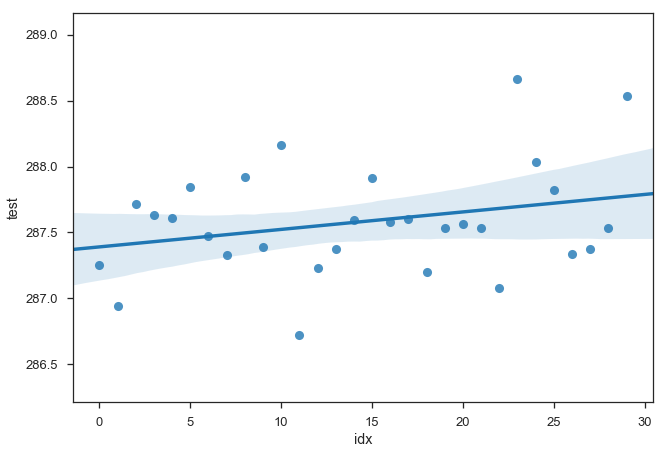

In [126]:
t = fgm_ensemble['TEMP']
# ds = t.isel(lat=7, lon=7)
ds = t.mean(['lat', 'lon'])
ds_yearly = ds.resample(time='AS').mean()
df = ds_yearly.to_dataframe('test').reset_index()
df['idx'] = range(len(df))
print(df.head())

import seaborn as sns

sns.regplot('idx', 'test', df)

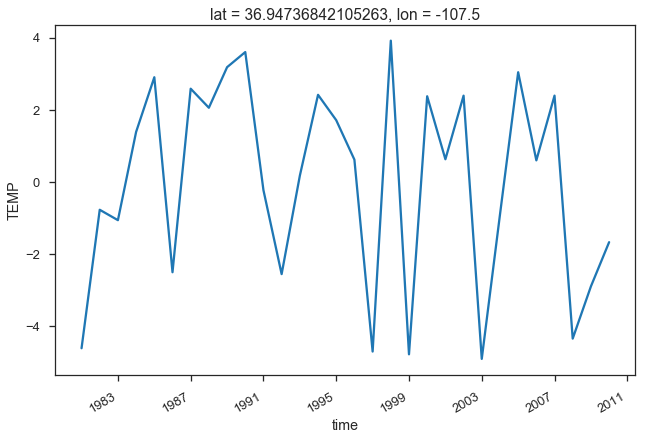

In [110]:
t = fgm_ensemble['TEMP']
ds = t.isel(lat=7, lon=7)
ms = MonthSelector(1, width=0)
ds = ms.fit_transform(ds)

(ds - ds.mean('time')).plot()

# Basic Example

For a simple example of how to use this toolkit, let's look at the following simple Principal Component Regression model, adapted from the example in [stat_pm25/models/simple.py]():

In [90]:
from stat_pm25.sklearn import *

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


class PCRModel(DatasetModel):
    """ Performs principal component regression model on gridded data.

    This class uses the `DatasetModel` framework to implement a principal
    component regression - a linear regression on a set of features which has
    been pre-processed using principal component analysis. It only requires a
    single additional argument on top of `DatasetModel`, the number of
    components to retain.

    This example illustrates how you can very easily put together complex
    analyses and deploy them onto your gridded model output, all using very
    simple building blocks.

    """

    def __init__(self, *args, n_components=3, month=6, **kwargs):
        # If you need to add arguments, add them as named keyword arguments in
        # the appropriate place (as shown above), and set them first in the
        # method.
        self.n_components = n_components
        self.month = month
        
        # Modify any pre-set parameters, or hard-code them otherwise. For
        # instance, if you want to pre-process your data, this would be the
        # place to specify how to do so. Doing so here has the advantage that
        # you will be able to immediately apply your `predict()` method
        # to new data without pre-processing it - all that logic will be
        # saved

        # Zero out dilat and dilon, since we don't need to search around
        # neighboring grid cells
        self.dilat = self.dilon = 0

        # Set a pre-processor pipeline
        self.preprocessor = Pipeline([
            ('subset_time', MonthSelector(self.month, width=0)),
            # We didn't include the de-trending component below
            ('detrend', YearlyMovingAverageDetrender())
        ])
        
        # Call the parent superconstructor
        super().__init__(*args, **kwargs)

    def cell_kernel(self, gcf):
        """ Fit a model at a single grid cell.

        """

        # First, get the predictand data at the grid cell we care about. We
        # don't necessarily have to be super pedantic about this; we can just
        # use normal xarray selection methods if we want, although comments
        # below is how we could accomplish this using our specialized
        # Transformer classes
        # local_selector = DatasetSelector(
        #     sel='isel', lon=gcf.ilon, lat=gcf.ilat
        # )
        # y = local_selector.fit_transform(self.data[self.predictand])
        y = self.data[self.predictand].isel(lat=gcf.ilat, lon=gcf.ilon)

        # Prepare features timeseries. We want to fully include all the steps
        # to extract our features from the original, full dataset in here
        # so that our logic for re-applying the pipeline for prediction
        # later on will work similarly
        _model = Pipeline([
            ('subset_latlon', DatasetSelector(
                sel='isel', lon=gcf.ilon, lat=gcf.ilat)
            ),
            ('predictors', FieldExtractor(self.predictors)),
            ('normalize', Normalizer()),
            ('dataset_to_array', DatasetAdapter(drop=['lat', 'lon'])),
            ('pca', PCA(n_components=self.n_components)),
            ('linear', LinearRegression()),
        ])

        # Fit the model/pipeline
        _model.fit(self.data, y)
        # Calculate some sort of score for archival
        _score = _model.score(self.data, y)
        # Encapsulate the result within a GridCellResukt
        gcr = GridCellResult(_model, self.predictand, self.predictors, 
                             _score, rand=np.random.randint(10), x=1)
        
        return gcr

Set up the model and fit it.

In [91]:
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']

train_data = fgm_ensemble.isel(time=slice(0, 12*25))
test_data = fgm_ensemble.isel(time=slice(12*25, None))

model = PCRModel(train_data, predictand, predictors, month=1,
                 verbose=True)
model.fit_parallel(3)

Loop over all grid cells:   0%|          | 0/360 [00:00<?, ?it/s]

Fitting pre-processor...


Loop over all grid cells: 100%|██████████| 360/360 [00:02<00:00, 148.95it/s]


Time elapsed =  1.5898650000000032


In [92]:
print(test_data)

<xarray.Dataset>
Dimensions:  (lat: 15, lon: 24, time: 59)
Coordinates:
  * lat      (lat) float64 23.68 25.58 27.47 29.37 31.26 33.16 35.05 36.95 ...
  * lon      (lon) float64 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 2006-03-01 ...
Data variables:
    PM25     (time, lat, lon) float64 27.91 27.98 28.02 27.72 23.52 14.27 ...
    TEMP     (time, lat, lon) float64 291.8 291.6 291.9 292.2 293.7 296.1 ...
    PRECIP   (time, lat, lon) float64 0.2968 0.2231 0.2083 0.3154 0.1333 ...
    RH       (time, lat, lon) float64 82.47 83.69 82.72 84.62 83.59 66.39 ...
    U        (time, lat, lon) float64 -6.188 -4.872 -3.558 -2.233 -1.485 ...
    V        (time, lat, lon) float64 -6.794 -6.589 -6.187 -5.564 -4.541 ...
Attributes:
    History:  Generated by 09_lu_shen_reproduction.ipynb (Apr 19, 2017 13:49)\n


In [95]:
test_pm25 = model.predict(test_data, preprocess=True)

Iterate over grid cell models:   6%|▌         | 22/360 [00:00<00:01, 214.11it/s]

Pre-processing data...


Iterate over grid cell models: 100%|██████████| 360/360 [00:01<00:00, 250.34it/s]


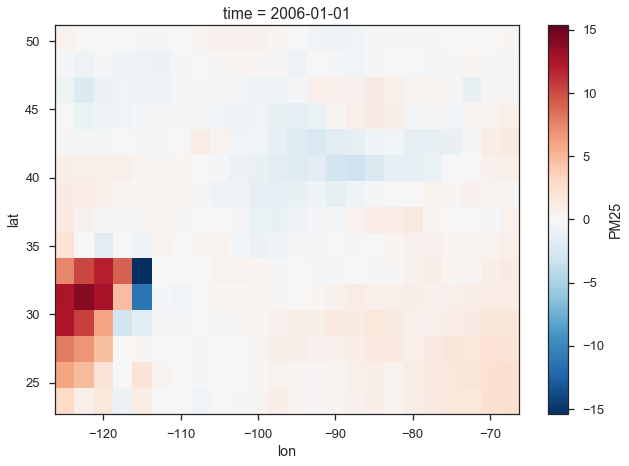

In [97]:
test_pm25.PM25.isel(time=0).plot.imshow()

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 552285.82it/s]


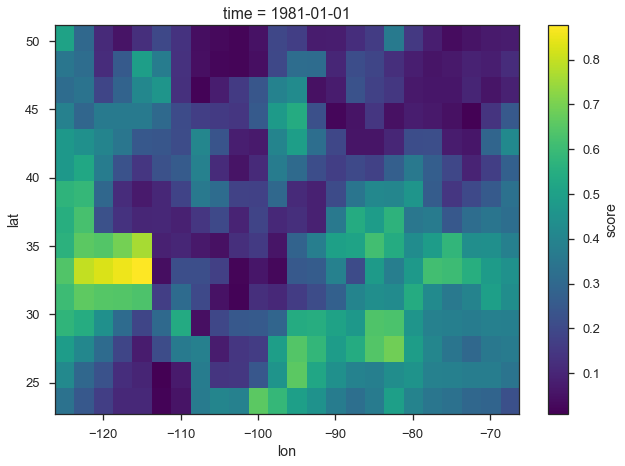

In [67]:
score = model.score
score.plot.imshow()

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 271086.08it/s]


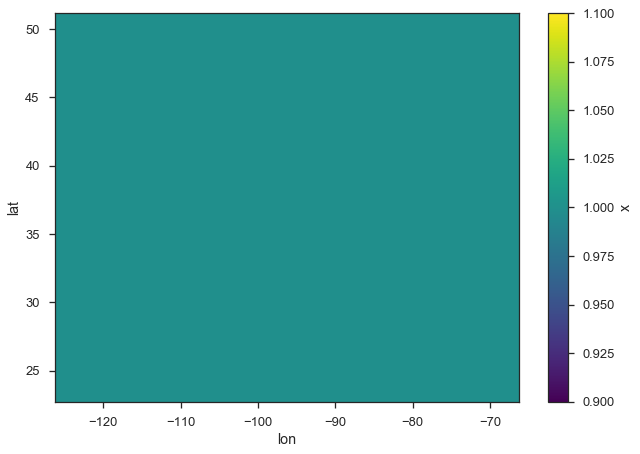

In [72]:
rand = model.get_result_stat('x')['x']
rand.plot.imshow()

In [73]:
for gcr, gcf in model._gcr_gcf_iter:
    print(gcr)

Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 7114.05it/s]

GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.336444]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.416509]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.488181]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.577908]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.605604]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.641537]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.568552]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.552694]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.574842]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.47284]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.473479]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.39]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.315176]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.351231]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.510182]
GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V [0.246934]
GridCellResul